<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.1
tiktoken version: 0.7.0
torch version: 2.4.0
tqdm version: 4.66.4
tensorflow version: 2.15.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to follow instructions better

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):
    """
    此函数用于从指定的URL下载文件（如果本地不存在该文件），然后将文件内容读取并解析为JSON格式的数据并返回。

    参数:
    - file_path: 本地文件路径，指定要保存或读取文件的位置。
    - url: 要下载文件的URL地址，用于获取远程文件的资源。

    返回值:
    - 返回解析后的JSON数据，如果文件不存在则先下载再解析，如果文件已存在则直接读取并解析。
    """

    # 判断本地指定的文件路径是否存在该文件
    if not os.path.exists(file_path):
        # 如果文件不存在，通过urllib.request.urlopen函数打开指定URL的资源连接
        with urllib.request.urlopen(url) as response:
            # 读取URL资源的内容，并将其从字节流解码为UTF-8编码的字符串格式，得到文本数据
            text_data = response.read().decode("utf-8")
        # 以写入模式打开本地指定的文件路径，设置编码为UTF-8
        with open(file_path, "w", encoding="utf-8") as file:
            # 将从URL读取并解码后的文本数据写入到本地文件中
            file.write(text_data)
    else:
        # 如果文件已经存在，以读取模式打开本地文件，编码为UTF-8
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # 再次以读取模式打开本地文件（无论是刚刚下载写入的还是原本就存在的），编码为UTF-8
    with open(file_path, "r", encoding="utf-8") as file:
        # 使用json.load函数将文件内容解析为JSON格式的数据
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

# 调用download_and_load_file函数，传入指定的文件路径和URL，获取解析后的JSON数据并赋值给变量data
data = download_and_load_file(file_path, url)
# 打印出获取到的JSON数据的条目数量，即数据中元素的个数
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below, we format the input that we will pass as input to the LLM

In [5]:
def format_input(entry):
    """
    该函数用于格式化输入数据，将输入数据中的指令（instruction）部分和可选的输入（input）部分按照特定的格式拼接成一个字符串。
    参数:
    - entry: 一个字典类型的数据，通常包含 'instruction' 和 'input' 等键值对，其中 'instruction' 键对应的值是描述任务的指令内容，'input' 键对应的值是与指令相关的具体输入内容（可能为空）。
    返回值:
    - 返回一个格式化后的字符串，按照特定格式拼接了指令内容和输入内容（如果有）。
    """
    # 首先处理指令文本部分，将指令内容按照指定的格式进行拼接。
    # 拼接的格式是先给出一段固定的描述性文字，说明下面是一个描述任务的指令，然后换行并添加 "### Instruction:\n" 作为指令部分的标题，
    # 接着跟上从输入数据entry中获取的指令内容（entry['instruction']）。
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    # 接着处理输入文本部分，如果输入数据entry中的 'input' 键对应的值不为空，
    # 则按照指定格式进行拼接，即先换行并添加 "### Input:\n" 作为输入部分的标题，然后跟上从输入数据entry中获取的输入内容（entry['input']）。
    # 如果 'input' 键对应的值为空，则将输入文本部分设置为空字符串。
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    # 最后将格式化好的指令文本和输入文本（如果有）拼接在一起，并返回拼接后的结果。
    return instruction_text + input_text

- A formatted response with input field looks like as shown below

In [6]:
# 调用format_input函数对数据中的第51个元素（索引为50）进行格式化输入操作。
# 该函数会根据传入的字典元素（这里是data[50]）中的'instruction'和'input'键值对信息，按照特定格式拼接成一个文本字符串，
# 作为后续提供给模型的输入内容。
model_input = format_input(data[50])
# 根据数据中的第51个元素（索引为50）的'output'键值对信息，按照特定格式拼接出期望的响应内容。
# 先换行并添加 "### Response:\n" 作为响应部分的标题，然后跟上从数据中获取的输出内容（data[50]['output']）。
desired_response = f"\n\n### Response:\n{data[50]['output']}"
# 将格式化后的模型输入内容和期望的响应内容拼接在一起，并打印输出结果。
# 这样可以直观地查看对于特定任务（由data[50]描述）的输入内容以及期望的响应内容，便于后续与模型实际生成的结果进行对比等操作。
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- Below is a formatted response without an input field

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

In [8]:
# 假设 'data' 是已有的数据集，其包含多个数据元素，比如与特定任务相关的数据记录。
# 计算训练集应占比例及截止索引
# 用数据集总长度乘0.85得训练集大致样本数，转整数确定截止索引，取前85%数据作训练集。
train_portion = int(len(data) * 0.85)  
# 计算测试集应占比例及起始索引
# 总长度乘0.1得测试集大致样本数，转整数确定起始索引，从训练集后取10%数据作测试集。
test_portion = int(len(data) * 0.1)  
# 计算验证集应占比例及起始索引
# 用总长度减去训练集、测试集样本数，得验证集起始索引，取剩余约5%数据作验证集。
val_portion = len(data) - train_portion - test_portion  
# 根据计算的索引划分数据集
# 取开头到'train_portion'索引的数据作训练集，用于训练模型。
train_data = data[:train_portion]
# 取'train_portion'到'train_portion + test_portion'索引的数据作测试集，用于测试模型性能。
test_data = data[train_portion:train_portion + test_portion]
# 取'train_portion + test_portion'索引到末尾的数据作验证集，用于训练中验证模型。
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

In [10]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    """
    InstructionDataset类是一个自定义的数据集类，继承自PyTorch的Dataset类。
    它的主要作用是将给定的数据按照特定格式进行处理和编码，以便能够作为模型的输入数据使用，并且可以与PyTorch的数据加载器（DataLoader）等工具配合使用。
    """
    def __init__(self, data, tokenizer):
        """
        类的初始化方法，用于设置数据集的相关属性和对数据进行预处理。
        参数:
        - data: 包含任务相关信息的数据集，通常是一个列表，其中每个元素是一个字典，字典中包含了如'instruction'、'input'、'output'等键值对，用于描述不同的任务指令、输入内容和输出内容等。
        - tokenizer: 分词器对象，用于对文本进行分词和编码操作，将文本转换为模型可处理的编码形式。
        """
        # 将传入的数据集赋值给self.data属性，以便在类的其他方法中可以访问和使用该数据集。
        self.data = data
        # 初始化一个空列表，用于存储经过预处理和编码后的文本数据。
        self.encoded_texts = []
        # 遍历数据集中的每个元素，对每个元素进行以下处理：
        for entry in data:
            # 首先调用format_input函数，根据元素中的'instruction'和'input'键值对信息，按照特定格式拼接出包含指令和输入内容的文本字符串。
            instruction_plus_input = format_input(entry)
            # 根据元素中的'output'键值对信息，按照特定格式拼接出包含输出内容的文本字符串，作为响应文本。
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 将包含指令和输入内容的文本字符串与包含输出内容的文本字符串拼接在一起，得到完整的文本内容。
            full_text = instruction_plus_input + response_text
            # 使用分词器的encode方法对完整的文本内容进行编码操作，将文本转换为模型可处理的编码形式，并将编码后的结果添加到self.encoded_texts列表中。
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    def __getitem__(self, index):
        """
        根据给定的索引获取数据集中的单个数据样本。
        参数:
        - index: 要获取的数据样本的索引。

        返回值:
        - 返回编码后的文本数据样本，即self.encoded_texts列表中对应索引位置的元素，该元素是经过分词器编码后的文本编码形式，可作为模型的输入数据。
        """
        return self.encoded_texts[index]

    def __len__(self):
        """
        返回数据集的大小，即数据集中包含的数据样本数量。

        返回值:
        - 返回一个整数，表示数据集的大小，其值等于self.data中包含的元素数量，也就是任务相关信息的数量。
        """
        return len(self.data)

- Similar to chapter 6, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- Also similar to the previous chapter, we use the `<|endoftext|>` token as a padding token

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- In chapter 6, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    """
    该函数用于对一批数据进行自定义的整理操作，主要包括找到批次中最长序列，对序列进行填充使其长度一致，并将整理好的数据转换为张量后移动到指定设备上。
    参数:
    - batch: 一批数据，通常是一个包含多个数据项的列表，每个数据项可能是一个序列（如编码后的文本序列等）。
    - pad_token_id: 用于填充的标记（token）的ID，默认为50256，当序列长度不足时用此ID进行填充。
    - device: 目标设备，默认为"cpu"，表示将整理好的数据移动到该设备上进行后续操作，也可以是"cuda"等GPU设备。
    返回值:
    - 返回一个整理好并移动到指定设备上的张量，包含了批次中经过填充和处理后的所有数据项。
    """
    # 找到批次中最长序列的长度，然后再加1，这额外的1是为了后续添加一个填充标记（在下面代码中会添加一个<|endoftext|>标记后再填充）。
    batch_max_length = max(len(item)+1 for item in batch)
    # 初始化一个空列表，用于存储处理后的每个数据项的张量形式。
    inputs_lst = []
    for item in batch:
        # 对批次中的每个数据项进行拷贝，以便在不影响原始数据的情况下进行处理。
        new_item = item.copy()
        # 在数据项末尾添加一个<|endoftext|>标记（这里用pad_token_id表示），模拟文本结束的情况。
        new_item += [pad_token_id]
        # 将数据项填充到批次最长长度batch_max_length，不足的部分用pad_token_id填充。
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 通过取切片padded[:-1]，去掉由于batch_max_length加1而额外添加的那个填充标记（这个额外填充标记在后续代码可能有用，但这里先去掉它以得到合适的输入张量）。
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    # 将处理好的每个数据项的张量列表转换为一个张量，并将其移动到指定设备上，以便后续在该设备上进行相关操作。
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    """
    该函数用于对输入的一批数据进行自定义的整理和划分操作，以便为模型提供合适的输入张量和目标张量。

    参数:
    - batch: 一批数据，通常是一个包含多个数据项的列表，每个数据项可能是一个序列（如编码后的文本序列等）。
    - pad_token_id: 用于填充的标记（token）的ID，默认为50256，当序列长度不足时用此ID进行填充。
    - device: 目标设备，默认为"cpu"，表示将整理好的数据移动到该设备上进行后续操作，也可以是"cuda"等GPU设备。
    返回值:
    - 返回两个张量，分别是经过整理和处理后的输入张量（inputs_tensor）和目标张量（targets_tensor），用于后续提供给模型进行相关操作，如训练等。
    """
    # 找到批次中最长序列的长度，然后再加1，这额外的1是为了后续添加一个填充标记（在下面代码中会添加一个<|endoftext|>标记后再填充）。
    batch_max_length = max(len(item)+1 for item in batch)
    # 初始化两个空列表，分别用于存储处理后的输入张量和目标张量的各个元素。
    inputs_lst, targets_lst = [], []
    for item in batch:
        # 对批次中的每个数据项进行拷贝，以便在不影响原始数据的情况下进行处理。
        new_item = item.copy()
        # 在数据项末尾添加一个<|endoftext|>标记（这里用pad_token_id表示），模拟文本结束的情况。
        new_item += [pad_token_id]
        # 将数据项填充到批次最长长度batch_max_length，不足的部分用pad_token_id填充。
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 对于输入张量，通过取切片padded[:-1]，去掉由于batch_max_length加1而额外添加的那个填充标记，得到合适的输入张量。
        inputs = torch.tensor(padded[:-1])
        # 对于目标张量，通过取切片padded[1:]，将序列整体向右移动一位，即去掉第一个标记作为输入的对应目标，得到目标张量。
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # 将处理好的输入张量列表转换为一个张量，并将其移动到指定设备上，以便后续在该设备上进行相关操作。
    inputs_tensor = torch.stack(inputs_lst).to(device)
    # 将处理好的目标张量列表转换为一个张量，并将其移动到指定设备上，以便后续在该设备上进行相关操作。
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """
    此函数用于对输入的一批数据进行自定义的整理和预处理操作，以便为后续的模型训练或其他相关操作提供合适的输入张量和目标张量。

    参数:
    - batch: 一批数据，通常是一个包含多个数据项的列表，每个数据项可能是一个序列（如编码后的文本序列等）。
    - pad_token_id: 用于填充的标记（token）的ID，默认为50256，当序列长度不足时用此ID进行填充。
    - ignore_index: 一个特定的值，用于在处理目标张量时，将某些不需要参与计算的标记替换为此值，默认为 -100。
    - allowed_max_length: 可选参数，用于指定允许的最大序列长度，如果不为None，则会对输入和目标张量进行截断操作，使其长度不超过此值。
    - device: 目标设备，默认为 "cpu"，表示将整理好的数据移动到该设备上进行后续操作，也可以是 "cuda" 等GPU设备。

    返回值:
    - 返回两个张量，分别是经过整理和处理后的输入张量（inputs_tensor）和目标张量（targets_tensor），可用于后续提供给模型进行训练、评估等操作。
    """
    # 找到批次中最长序列的长度，然后再加1。
    # 加1的目的是为了后续能添加一个填充标记（在下面代码中会添加一个<|endoftext|>标记后再填充）。
    batch_max_length = max(len(item)+1 for item in batch)
    # 初始化两个空列表，分别用于存储处理后的输入张量和目标张量的各个元素。
    inputs_lst, targets_lst = [], []
    for item in batch:
        # 对批次中的每个数据项进行拷贝，以便在不影响原始数据的情况下进行处理。
        new_item = item.copy()
        # 在数据项末尾添加一个<|endoftext|>标记（这里用pad_token_id表示），模拟文本结束的情况。
        new_item += [pad_token_id]
        # 将数据项填充到批次最长长度batch_max_length，不足的部分用pad_token_id填充。
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 对于输入张量，通过取切片padded[:-1]，去掉由于batch_max_length加1而额外添加的那个填充标记，得到合适的输入张量。
        inputs = torch.tensor(padded[:-1])

        # 对于目标张量，通过取切片padded[1:]，将序列整体向右移动一位，即去掉第一个标记作为输入的对应目标，得到目标张量。
        targets = torch.tensor(padded[1:])

        # 新添加的功能：将目标张量中除了第一个填充标记之外的所有填充标记替换为ignore_index。
        # 首先创建一个掩码，用于标识目标张量中哪些元素等于pad_token_id（即填充标记）。
        mask = targets == pad_token_id
        # 找到掩码中值为True的元素的索引，返回一个张量，然后通过squeeze方法将维度为1的维度压缩掉（如果有的话），得到一维的索引张量。
        indices = torch.nonzero(mask).squeeze()
        # 如果找到的填充标记索引数量大于1（即除了第一个填充标记外还有其他填充标记），
        # 则将除了第一个填充标记之外的所有填充标记对应的目标张量中的元素替换为ignore_index。
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        # 新添加的功能：如果设置了allowed_max_length（即允许的最大序列长度）不为None，
        # 则对输入和目标张量进行截断操作，使其长度不超过allowed_max_length。
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # 将处理好的输入张量列表转换为一个张量，并将其移动到指定设备上，以便后续在该设备上进行相关操作。
    inputs_tensor = torch.stack(inputs_lst).to(device)

    # 将处理好的目标张量列表转换为一个张量，并将其移动到指定设备上，以便后续在该设备上进行相关操作。
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss

In [19]:
import torch.nn.functional as F
# 创建一个二维张量logits_1，用于表示模型对两个训练样本的预测结果（以对数几率的形式）。
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
# 创建一个一维张量targets_1，用于表示两个训练样本的真实类别标签。
# 这里的0和1分别对应着前面logits_1中每个样本预测的两个类别中的其中一个，
targets_1 = torch.tensor([0, 1])
# 使用PyTorch的nn.functional模块中的cross_entropy函数来计算交叉熵损失。
# 交叉熵损失常用于衡量模型预测结果与真实标签之间的差异，在分类问题中是一种常用的损失函数。
# 传入模型的预测对数几率值（logits_1）和真实类别标签（targets_1）作为参数，
# 函数会根据这两个参数计算出模型在这两个训练样本上的交叉熵损失值。
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)

# 打印出计算得到的交叉熵损失值，以便查看模型在这两个训练样本上的预测结果与真实标签之间的差异程度。
# 损失值越小，说明模型的预测结果越接近真实标签，模型的性能相对越好。
print(loss_1)

tensor(0.7936)


- Let's see what happens if we replace the class label of one of the examples with -100

In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [23]:
from torch.utils.data import DataLoader
# 设置用于数据加载的工作进程数量为0。在数据加载过程中，可以使用多个工作进程来并行加载数据，以提高数据加载的效率。
# 这里设置为0表示不使用多进程加载数据，而是在主线程中顺序加载数据，通常在一些简单的场景或者调试时可能会这样设置。
num_workers = 0
# 设置每个批次的数据量大小为8。即每次从数据集中取出8个数据样本组成一个批次，这些批次将被提供给模型进行处理，
# 比如在训练模型时，模型会对每个批次的数据进行一次前向传播和反向传播等操作。
batch_size = 8
torch.manual_seed(123)
# 创建一个InstructionDataset类型的训练数据集对象。InstructionDataset是一个自定义的数据集类（假设前面已经定义好），
# 它接受两个参数：train_data和tokenizer。train_data应该是已经划分好的用于训练的数据集部分（例如通过前面的代码按照一定比例从原始数据集中划分出来的），
# tokenizer是一个分词器对象，用于对数据集中的文本数据进行分词和编码等操作，使得数据能够以合适的形式提供给模型。
train_dataset = InstructionDataset(train_data, tokenizer)
# 创建一个DataLoader对象，用于加载训练数据集train_dataset中的数据。DataLoader是PyTorch中用于方便地加载数据的工具类，
# 它可以按照设定的参数将数据集分成批次、进行数据的打乱、多进程加载等操作。
# 传入训练数据集对象train_dataset，指定要加载的数据来源。
train_loader = DataLoader(
    train_dataset,
    # 设置每个批次的数据量大小为前面定义的batch_size，即每次加载8个数据样本组成一个批次。
    batch_size=batch_size,
    # 指定一个自定义的整理函数customized_collate_fn（假设前面已经定义好），用于对每个批次的数据进行整理和预处理操作，
    # 比如对数据进行填充、生成合适的输入张量和目标张量等，使得数据能够以合适的形式提供给模型。
    collate_fn=customized_collate_fn,
    # 设置为True，表示在每次迭代加载数据时，对数据集进行随机打乱操作，这样可以使得模型在每次训练批次中看到的数据顺序不同，
    # 有助于提高模型的泛化能力，避免模型过度依赖数据的特定顺序。
    shuffle=True,
    # 设置为True，表示如果最后一个批次的数据量不足batch_size时，丢弃这个不完整的批次。
    # 这样可以保证每个批次的数据量都是固定的batch_size，便于模型进行统一的处理。
    drop_last=True,
    # 设置用于数据加载的工作进程数量为前面定义的num_workers，这里是0，表示不使用多进程加载数据，在主线程中顺序加载数据。
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
# 创建验证数据加载器对象
# 使用PyTorch的DataLoader类来创建验证数据加载器val_loader，用于加载验证数据集val_dataset中的数据。
val_loader = DataLoader(
    val_dataset,
    # 设置每个批次的数据量大小为之前定义好的batch_size，这里同样是每次取8个数据样本组成一个批次，以便后续提供给模型进行验证时以批次为单位进行处理。
    batch_size=batch_size,
    # 指定使用之前定义好的自定义整理函数customized_collate_fn对每个批次的数据进行整理和预处理操作。
    # 该函数会对数据进行诸如填充、生成合适的输入张量和目标张量等操作，使得数据能够以合适的形式提供给模型进行验证。
    collate_fn=customized_collate_fn,
    # 设置为False，表示在加载验证数据时不需要对数据集进行随机打乱操作。
    # 因为验证集主要是用于在模型训练过程中评估模型在未见过的数据上的性能，通常希望保持数据的原始顺序来进行准确的评估。
    shuffle=False,
    # 设置为False，表示如果最后一个批次的数据量不足batch_size时，不丢弃这个不完整的批次。
    # 与训练集不同，验证集通常不需要严格保证每个批次的数据量都是固定的batch_size，保留所有数据以便全面评估模型性能。
    drop_last=False,
    # 设置用于数据加载的工作进程数量为之前定义好的num_workers，这里同样是按照之前设定的值（比如之前设为0）来确定是否使用多进程加载数据以及使用多少个工作进程。
    num_workers=num_workers
)
test_dataset = InstructionDataset(test_data, tokenizer)
# 创建测试数据加载器对象
# 使用DataLoader类来创建测试数据加载器test_loader，用于加载测试数据集test_dataset中的数据。
test_loader = DataLoader(
    test_dataset,
    # 设置每个批次的数据量大小为batch_size，即每次取8个数据样本组成一个批次，以便后续提供给模型进行测试时以批次为单位进行处理。
    batch_size=batch_size,
    # 指定使用customized_collate_fn函数对每个批次的数据进行整理和预处理操作，使得数据能够以合适的形式提供给模型进行测试。
    collate_fn=customized_collate_fn,
    # 设置为False，表示在加载测试数据时不需要对数据集进行随机打乱操作。
    # 因为测试集主要是用于在模型训练完成后评估模型在全新的未见过的数据上的性能，保持数据的原始顺序有助于准确评估模型的泛化能力。
    shuffle=False,
    # 设置为False，表示如果最后一个批次的数据量不足batch_size时，不丢弃这个不完整的批次。
    # 测试集同样通常不需要严格保证每个批次的数据量都是固定的batch_size，保留所有数据以便全面评估模型性能。
    drop_last=False,
    # 设置用于数据加载的工作进程数量为num_workers，按照之前设定的值来确定是否使用多进程加载数据以及使用多少个工作进程。
    num_workers=num_workers
)

- Let's see what the dimensions of the resulting input and target batches look like

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [28]:
# 从gpt_download模块中导入download_and_load_gpt2函数，该函数可能用于下载和加载GPT相关模型及其参数等操作。
from gpt_download import download_and_load_gpt2
# 从previous_chapters模块中导入GPTModel类和load_weights_into_gpt函数，
# GPTModel类可能用于定义GPT模型的结构，load_weights_into_gpt函数可能用于将加载的参数加载到GPT模型中。
from previous_chapters import GPTModel, load_weights_into_gpt

# 定义一个基础配置字典BASE_CONFIG，用于设置GPT模型的一些通用参数。
BASE_CONFIG = {
    # 词汇表大小，这里设置为50257，表示模型能够识别和处理的不同词汇的数量。
    "vocab_size": 50257,  
    # 上下文长度，即模型在处理文本时能够考虑的文本序列的最大长度，这里设置为1024个 tokens（例如单词、字符等文本单元）。
    "context_length": 1024,  
    #  dropout率，用于在训练过程中随机丢弃一些神经元的连接，以防止模型过拟合，这里设置为0.0，表示不进行丢弃操作（在某些情况下可能需要根据实际情况调整）。
    "drop_rate": 0.0,  
    # 查询-键-值（Query-Key-Value）偏差，设置为True表示在模型的某些注意力机制相关的计算中包含偏差项（具体取决于GPT模型的实现细节）。
    "qkv_bias": True  
}

# 定义一个字典model_configs，用于存储不同规模的GPT2模型的特定配置参数。
model_configs = {
    # "gpt2-small (124M)"模型的配置参数，其中emb_dim表示嵌入维度为768，n_layers表示模型层数为12，n_heads表示注意力头的数量为12。
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    # "gpt2-medium (355M)"模型的配置参数，嵌入维度为1024，层数为24，注意力头数量为16。
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    # "gpt2-large (774M)"模型的配置参数，嵌入维度为1280，层数为36，注意力头数量为20。
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    # "gpt2-xl (1558M)"模型的配置参数，嵌入维度为1600，层数为48，注意力头数量为25。
    "gpt2-xl (1558M)" : {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# 选择要使用的模型，这里选择了"gpt2-medium (355M)"模型，后续将基于此模型进行相关的操作，如加载、配置等。
CHOOSE_MODEL = "gpt2-medium (355M)"
# 将选择的模型的特定配置参数更新到基础配置字典BASE_CONFIG中，这样BASE_CONFIG就包含了所选模型的完整配置信息。
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
# 从选择的模型名称中提取出模型的大小信息，例如从"gpt2-medium (355M)"中提取出"355M"，以便后续在下载和加载模型等操作中使用。
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# 调用download_and_load_gpt2函数，传入提取出的模型大小信息和指定的模型存储目录"gpt2"，
# 该函数可能会根据传入的参数下载相应的GPT2模型，并加载相关的设置和参数，返回设置信息和参数信息。
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)
# 使用更新后的BASE_CONFIG配置信息创建一个GPTModel类的实例，即创建一个GPT模型对象，该对象具有所选模型的特定结构和参数设置。
model = GPTModel(BASE_CONFIG)
# 调用load_weights_into_gpt函数，将下载和加载得到的参数params加载到创建好的GPT模型model中，使模型具有合适的权重参数，以便进行后续的评估或其他操作。
load_weights_into_gpt(model, params)
# 将模型设置为评估模式，在这种模式下，模型的一些层（如Dropout层等）会按照评估时的行为进行设置，
# 例如Dropout层在评估时通常不会进行随机丢弃操作，以便能够得到稳定的输出结果，用于对模型进行评估等操作。
model.eval();

2024-07-25 02:22:49.969483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 02:22:50.023103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 02:22:50.023136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 02:22:50.024611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 02:22:50.033304: I tensorflow/core/platform/cpu_feature_guar

- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [29]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
# 从previous_chapters模块中导入三个函数：generate、text_to_token_ids和token_ids_to_text。
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# 调用generate函数来生成新的文本token IDs。
# 传入模型对象model，该模型应该是已经经过前面的步骤（如创建、加载权重等操作）准备好的模型，能够基于输入进行文本生成等操作。
model=model,
# 使用text_to_token_ids函数将输入文本input_text转换为token IDs。
# 这里的tokenizer应该是之前定义好的用于对文本进行分词和编码的分词器对象，它能够将输入文本按照一定的规则转换为模型可处理的token IDs形式。
idx=text_to_token_ids(input_text, tokenizer),
# 设置要生成的新的token数量上限为35个。也就是说，生成函数generate将会基于输入的token IDs生成最多35个新的token IDs，用于后续生成新的文本内容。
max_new_tokens=35,
# 设置上下文大小为BASE_CONFIG字典中"context_length"键对应的值。
# 这个上下文大小表示模型在生成文本时能够考虑的之前的文本序列的长度范围，它决定了模型在生成新文本时可以参考的历史信息的多少。
context_size=BASE_CONFIG["context_length"],

# 设置结束标记（End-of-Sequence）的ID为50256。当生成的token IDs中出现这个ID时，可能表示生成过程应该结束，具体取决于generate函数的实现细节。
eos_id=50256,
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

# 调用token_ids_to_text函数，将生成的token IDs转换为可阅读的文本形式。
# 传入生成的token IDs以及之前使用的分词器tokenizer，函数会根据分词器的规则将token IDs还原为对应的文本内容。
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

In [31]:
# 从生成的文本generated_text中提取出在输入文本input_text之后的部分内容。
response_text = generated_text[len(input_text):]
# 对提取出来的响应部分文本进行处理，将其中的"### Response:"字符串替换为空字符串。
response_text = response_text.replace("### Response:", "")
# 对处理后的文本进行去除首尾空白字符的操作。
# 在前面的替换操作等过程中可能会引入一些额外的空白字符，通过strip()函数可以将这些首尾的空白字符去除，
# 使得最终得到的响应文本更加整洁、规范，方便后续查看和使用。
response_text = response_text.strip()
# 打印出最终处理好的响应文本内容，以便查看模型基于输入文本生成的具体响应结果。
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 7.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters

In [32]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)

In [33]:
model.to(device)
torch.manual_seed(123)
# 使用torch.no_grad()上下文管理器，在这个上下文环境中，所有的计算都不会进行梯度计算。
# 这通常用于在模型评估阶段，因为在评估模型性能（如计算损失值）时，我们不需要计算梯度来更新模型的参数，
with torch.no_grad():
    # 调用calc_loss_loader函数来计算模型在训练数据集上的损失值。
    # 传入训练数据加载器（train_loader），它负责按批次提供训练数据给模型；传入模型对象（model），用于对数据进行预测并计算损失；
    # 传入指定的设备（device），确保计算在正确的设备上进行；还传入了num_batches=5，表示只计算前5个批次的数据的损失值，
    # 可能是为了快速得到一个大致的损失情况或者在调试阶段进行初步的评估，具体取决于实际需求。
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    # 同样调用calc_loss_loader函数来计算模型在验证数据集上的损失值。
    # 传入验证数据加载器（val_loader）、模型对象（model）、指定设备（device）以及num_batches=5，计算前5个批次的验证数据的损失值，
    # 用于评估模型在未见过的验证数据上的性能表现，与训练损失值对比可以帮助判断模型是否存在过拟合等情况。
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
# 打印出模型在训练数据集上的损失值，以便查看模型在训练数据上的性能表现情况，损失值越小通常表示模型对训练数据的拟合程度越好。
print("Training loss:", train_loss)
# 打印出模型在验证数据集上的损失值，通过与训练损失值对比等分析，可以了解模型在未见过的验证数据上的性能，
# 若验证损失值远大于训练损失值，可能提示模型存在过拟合现象；若两者较为接近，则说明模型的泛化能力可能较好。
print("Validation loss:", val_loss)

Training loss: 3.82590970993042
Validation loss: 3.761933755874634


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [34]:
import time

# 获取当前时间，作为训练开始的时间记录，后续用于计算训练过程所花费的时间。
start_time = time.time()
# 设置随机种子为123。这一步很重要，因为在后续的模型训练过程中，可能涉及到数据加载顺序、模型初始化等一些随机操作，
# 设置相同的随机种子可以保证每次运行程序都能得到相同的随机结果，便于调试和重现实验结果。
torch.manual_seed(123)
# 创建一个优化器对象optimizer，这里使用的是AdamW优化器，它是一种常用的基于随机梯度下降的优化算法的变种，常用于深度学习模型的训练。
# 传入模型的可训练参数model.parameters()，表示要优化的对象是模型的所有可训练参数；
# 同时设置学习率lr为0.00005，学习率决定了每次更新模型参数时的步长大小，较小的学习率通常意味着更新更加谨慎，可能需要更多的训练迭代次数；
# 设置权重衰减weight_decay为0.1，权重衰减用于防止模型过拟合，它会在每次更新参数时对参数的大小进行一定程度的惩罚，使得模型参数不会变得过大。
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
# 设置训练的轮数为2。训练轮数表示整个训练数据集被完整遍历的次数，一般来说，更多的训练轮数可能会使模型更好地拟合数据，但也可能导致过拟合，需要根据具体情况进行调整。
num_epochs = 2
# 调用train_model_simple函数来进行模型的训练操作。
# 该函数会在训练过程中返回训练损失值列表train_losses、验证损失值列表val_losses以及处理过的令牌数量tokens_seen（具体含义取决于函数内部实现）。
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
# 获取当前时间，作为训练结束的时间记录。
end_time = time.time()
# 计算训练过程所花费的时间，将结束时间减去开始时间得到总秒数，再除以60将其转换为分钟数，得到执行时间的分钟表示形式。
execution_time_minutes = (end_time - start_time) / 60
# 打印出训练完成所花费的时间，格式化为保留两位小数的分钟数形式，以便直观地查看训练过程的耗时情况。
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

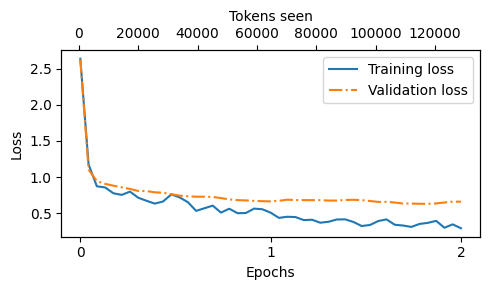

In [35]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

## 7.7 Extracting and saving responses

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [36]:
import torch
# 设置随机种子为123。这一步操作很重要，因为在后续的代码执行过程中，例如数据处理、模型生成等环节可能涉及到一些随机操作（如随机初始化等），
# 设置相同的随机种子可以保证每次运行程序都能得到相同的随机结果，便于调试和重现实验结果。
torch.manual_seed(123)
# 遍历测试数据中的前三个数据条目（通过切片test_data[:3]获取）。
# 对于每个数据条目，将执行以下一系列操作来生成模型的响应并与正确响应进行对比展示。
for entry in test_data[:3]:
    # 调用format_input函数对当前数据条目entry进行格式化处理，得到适合作为模型输入的文本格式。
    # 该函数可能会根据数据条目中的指令（instruction）和输入（input）等信息按照特定的格式拼接成一个完整的输入文本。
    input_text = format_input(entry)
    # 调用generate函数来生成新的文本token IDs。
    # 传入模型对象model，该模型应该是已经经过训练等操作，可以基于输入进行文本生成的模型。
    model=model,
    # 使用text_to_token_ids函数将格式化后的输入文本input_text转换为token IDs，并将其移动到指定的设备（device）上。
    # 这里的tokenizer是之前定义好的用于对文本进行分词和编码的分词器对象，它能够将输入文本按照一定的规则转换为模型可处理的token IDs形式，
    # 然后通过.to(device)将生成的token IDs张量移动到指定设备上，以便在该设备上进行后续的生成操作。
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    # 设置要生成的新的token数量上限为256个。也就是说，生成函数generate将会基于输入的token IDs生成最多256个新的token IDs，用于后续生成新的文本内容。
    max_new_tokens=256,
    # 设置上下文大小为BASE_CONFIG字典中"context_length"键对应的值。
    # 这个上下文大小表示模型在生成文本时能够考虑的之前的文本序列的长度范围，它决定了模型在生成新文本时可以参考的历史信息的多少。
    context_size=BASE_CONFIG["context_length"],
    # 设置结束标记（End-of-Sequence）的ID为50256。当生成的token IDs中出现这个ID时，可能表示生成过程应该结束，具体取决于generate函数的实现细节。
    eos_id=50256
    )
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    # 调用token_ids_to_text函数，将生成的token IDs转换为可阅读的文本形式。
    # 传入生成的token IDs以及之前使用的分词器tokenizer，函数会根据分词器的规则将token IDs还原为对应的文本内容。
    generated_text = token_ids_to_text(token_ids, tokenizer)

    # 从生成的文本generated_text中提取出在输入文本input_text之后的部分内容，作为模型生成的响应部分。
    # 这样做的目的是为了获取到模型基于输入文本生成的新内容，而去除掉输入文本本身的部分，因为我们主要关心的是模型生成的响应部分，而不是输入部分。
    response_text = (
        generated_text[len(input_text):]
       .replace("### Response:", "")
       .strip()
    )
    # 打印出格式化后的输入文本，以便查看作为模型输入的具体内容。
    print(input_text)
    # 打印出正确的响应内容，即从当前数据条目entry的'output'键获取的内容，作为与模型生成的响应进行对比的标准。
    print(f"\nCorrect response:\n>> {entry['output']}")
    # 打印出模型生成的响应内容，经过去除首尾空白字符等处理后的文本内容，以便与正确响应进行对比查看模型的生成效果。
    print(f"\nModel response:\n>> {response_text.strip()}")
    # 打印一条分隔线，用于在每个数据条目的输入、正确响应和模型响应展示之间进行分隔，使输出结果更加清晰易读。
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [37]:
from tqdm import tqdm

# 使用tqdm库来创建一个进度条，用于显示循环处理测试数据的进度情况。
# enumerate函数用于同时获取测试数据中每个元素的索引和元素本身，tqdm会根据总数据量（通过total=len(test_data)指定）来显示进度条的完成情况。
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    # 调用format_input函数对当前数据条目entry进行格式化处理，得到适合作为模型输入的文本格式。
    # 该函数可能会根据数据条目中的指令（instruction）和输入（input）等信息按照特定的格式拼接成一个完整的输入文本。
    input_text = format_input(entry)
    # 调用generate函数来生成新的文本token IDs。
    # 传入模型对象model，该模型应该是已经经过训练等操作，可以基于输入进行文本生成的模型。
    model=model,
    # 使用text_to_token_ids函数将格式化后的输入文本input_text转换为token IDs，并将其移动到指定的设备（device）上。
    # 这里的tokenizer是之前定义好的用于对文本进行分词和编码的分词器对象，它能够将输入文本按照一定的规则转换为模型可处理的token IDs形式，
    # 然后通过.to(device)将生成的token IDs张量移动到指定设备上，以便在该设备上进行后续的生成操作。
    idx=text_to_token_ids(input_text, tokenizer).to(device),

    # 设置要生成的新的token数量上限为256个。也就是说，生成函数generate将会基于输入的token IDs生成最多256个新的token IDs，用于后续生成新的文本内容。
    max_new_tokens=256,

    # 设置上下文大小为BASE_CONFIG字典中"context_length"键对应的值。
    # 这个上下文大小表示模型在生成文本时能够考虑的之前的工作序列的长度范围，它决定了模型在生成新文本时可以参考的历史信息的多少。
    context_size=BASE_CONFIG["context_length"],
    # 设置结束标记（End-of-Sequence）的ID为50256。当生成的token IDs中出现这个ID时，可能表示生成过程应该结束，具体取决于generate函数的实现细节。
    eos_id=50256
    )
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    # 调用token_ids_to_text函数，将生成的token IDs转换为可阅读的文本形式。
    # 传入生成的token IDs以及之前使用的分词器tokenizer，函数会根据分词器的规则将token IDs还原为对应的文本内容。
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 从生成的文本generated_text中提取出在输入文本input_text之后的部分内容，作为模型生成的响应部分。
    # 这样做的目的是为了获取到模型基于输入文本生成的新内容，而去除掉输入文本本身的部分，因为我们主要关心的是模型生成的响应部分，而不是输入部分。
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    # 将模型生成的响应内容response_text添加到当前测试数据条目test_data[i]的'model_response'键下，以便后续可以保存整个测试数据及对应的模型响应信息。
    test_data[i]["model_response"] = response_text
# 打开一个名为"instruction-data-with-response.json"的文件，以写入模式（"w"）打开，如果文件不存在则会创建它。
with open("instruction-data-with-response.json", "w") as file:
    # 使用json.dump函数将更新后的测试数据test_data保存到打开的文件中。
    # 设置indent=4参数，这会使保存的JSON数据以缩进格式进行输出，也就是进行"漂亮打印"，使JSON文件的内容更易读，便于查看和后续处理。
    json.dump(test_data, file, indent=4)  

100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- Finally, we also save the model in case we want to reuse it in the future

In [39]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the finetuned LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [1]:
import psutil

# 定义一个函数check_if_running，用于检查指定名称的进程是否正在运行。
def check_if_running(process_name):
    """
    该函数用于检查指定名称的进程是否在系统中正在运行。
    参数:
    - process_name: 要检查的进程名称的字符串。
    返回值:
    - 如果找到指定名称的进程正在运行，则返回True；否则返回False。
    """
    # 初始化一个变量running为False，表示默认情况下进程未在运行。
    running = False
    # 使用psutil库的process_iter方法来迭代系统中当前正在运行的所有进程。
    # 传入参数["name"]表示只获取每个进程的名称信息，这样可以提高遍历效率，避免获取不必要的进程详细信息。
    for proc in psutil.process_iter(["name"]):
        # 检查当前遍历到的进程的名称（通过proc.info["name"]获取）中是否包含要查找的进程名称process_name。
        if process_name in proc.info["name"]:
            # 如果包含，则说明找到了指定名称的进程正在运行，将running变量设置为True。
            running = True
            # 一旦找到目标进程，就不需要再继续遍历其他进程了，使用break语句跳出循环。
            break
    # 返回最终的结果，即表示指定进程是否正在运行的布尔值。
    return running
# 调用check_if_running函数来检查名为"ollama"的进程是否正在运行，并将结果存储在ollama_running变量中。
ollama_running = check_if_running("ollama")
# 如果ollama_running为False，即表示名为"ollama"的进程未在运行，那么抛出一个运行时错误（RuntimeError）。
# 错误信息提示用户需要先启动ollama进程，然后才能继续后续的操作。
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
# 再次调用check_if_running函数来检查名为"ollama"的进程是否正在运行，并打印出检查结果。
# 这里主要是为了在确认进程启动要求满足（如果前面没有抛出错误）后，再次确认进程的运行状态并展示给用户。
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [2]:
# 这段代码所在的单元格是可选的，它的作用是允许你重新启动笔记本（notebook），
# 并且只运行第7.7节的内容，而无需重新运行之前的任何代码。
import json
from tqdm import tqdm
# 指定要读取的JSON文件的路径，这个文件应该包含了之前处理过并保存下来的测试数据，
# 其中可能包含了如指令（instruction）、输入（input）等相关信息，以及可能已经生成的模型响应等内容。
file_path = "instruction-data-with-response.json"

# 使用Python的内置函数open以只读模式（"r"）打开指定路径的文件，
# 并将文件对象赋值给变量file，后续将通过这个文件对象来读取文件中的数据。
with open(file_path, "r") as file:
    # 使用json模块的load函数从打开的文件中读取JSON数据，并将其转换为Python对象（在这里应该是一个字典或列表等数据结构），
    # 然后将读取到的数据赋值给test_data变量，以便后续对这些测试数据进行处理和操作。
    test_data = json.load(file)
# 定义一个函数format_input，用于对输入数据条目中的指令和输入部分进行格式化处理，
# 生成一个适合作为模型输入的文本格式。
def format_input(entry):
    """
    该函数用于对给定的数据条目进行格式化处理，将其中的指令和输入部分按照特定格式拼接成一个完整的文本，
    以便作为模型的输入内容。
    参数:
    - entry: 一个包含指令（instruction）和输入（input）等信息的字典数据条目。

    返回值:
    - 返回一个按照特定格式拼接好的文本字符串，可作为模型的输入内容。
    """
    # 首先拼接指令部分的文本内容。
    # 这里构建了一个字符串，说明下面是一个描述任务的指令，然后添加实际的指令内容，
    # 并使用"\n\n### Instruction:\n"作为指令部分的标题格式，将实际指令内容包裹在其中，使其格式更加清晰。
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 接着处理输入部分的文本内容。
    # 如果数据条目中的输入部分（entry["input"]）不为空字符串，那么按照特定格式拼接输入内容，
    # 使用"\n\n### Input:\n"作为输入部分的标题格式，将实际输入内容包裹在其中；
    # 如果输入部分为空字符串，那么就将input_text设置为空字符串，表示没有额外的输入内容。
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # 最后将格式化好的指令文本和输入文本拼接在一起，返回拼接后的完整文本内容，
    # 这个完整文本将作为适合模型输入的格式提供给后续的模型处理等操作。
    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [3]:
import urllib.request
import json

# 定义一个函数query_model，用于向指定的模型发送查询请求并获取响应内容。
def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    """
    该函数用于向指定的模型发送包含提示信息的查询请求，并获取模型返回的响应内容。

    参数:
    - prompt: 要发送给模型的提示文本，即用户输入的问题或指令等内容。
    - model: 要查询的模型名称，默认为"llama3"，可根据实际情况进行修改。
    - url: 发送请求的目标URL地址，默认为"http://localhost:11434/api/chat"，指向模型的API接口地址，可根据模型部署的实际情况调整。

    返回值:
    - 返回从模型获取到的响应内容，以字符串形式呈现。
    """
    # 创建一个字典作为数据负载（payload），用于构建要发送给模型的请求数据。
    data = {
        # 指定要查询的模型名称。
        "model": model,
        # 设置消息列表，其中包含一条用户发送的消息。
        # 消息的角色为"user"，表示是用户发出的内容，内容就是传入的提示文本prompt。
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            # 以下设置是为了获取确定性的响应，即在相同的输入条件下能得到相同的输出结果。

            # 设置随机种子为123，这样在模型生成响应的过程中，如果涉及到随机因素，会基于这个种子产生固定的随机序列，从而得到确定的响应。
            "seed": 123,
            # 设置温度参数为0，温度参数控制着模型生成响应时的随机性。
            # 当温度为0时，模型会选择概率最高的输出作为响应，生成的结果相对比较确定，随机性较低。
            "temperature": 0,
            # 设置上下文长度为2048，表示模型在生成响应时能够考虑的之前的文本序列的最大长度为2048个单位（如字符、单词等）。
            "num_ctx": 2048
        }
    }
    # 将字典形式的数据转换为JSON格式的字符串，并将其编码为字节流，以便通过网络请求发送给模型。
    payload = json.dumps(data).encode("utf-8")

    # 创建一个urllib.request.Request对象，用于构建发送给模型的HTTP请求。
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")
    # 发送请求并捕获响应内容。
    # 初始化一个空字符串，用于存储从模型获取到的响应数据。
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # 循环读取响应内容，每次读取一行并进行解码处理，直到读取到空行为止，表示响应内容读取完毕。
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data
# 指定要查询的模型名称为"llama3"。
model = "llama3"
# 调用query_model函数，向指定模型发送查询请求，询问"What do Llamas eat?"，并获取模型的响应结果。
result = query_model("What do Llamas eat?", model)
# 打印出模型返回的响应内容，以便查看模型对该问题的回答。
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [4]:
# 遍历测试数据中的前三个数据条目（通过切片test_data[:3]获取）。
for entry in test_data[:3]:
    # 构建一个提示文本prompt，用于向模型发送查询请求，让模型根据给定的输入、正确输出以及模型自身生成的响应来进行评分。
    # 提示文本的内容是要求模型在0到100的范围内，对模型响应进行评分，其中100表示最佳分数。
    # 这里通过格式化字符串的方式，将当前数据条目经过format_input函数处理后的输入内容、正确输出以及模型生成的响应都包含在提示文本中。
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    # 打印出当前数据条目的正确输出内容，作为参考信息展示给用户，方便用户对比模型的评分结果与实际的正确输出。
    print("\nDataset response:")
    print(">>", entry['output'])
    # 打印出当前数据条目的模型生成的响应内容，同样作为参考信息展示给用户，以便用户了解模型针对该输入所生成的具体响应情况。
    print("\nModel response:")
    print(">>", entry["model_response"])
    # 打印出提示信息，表示接下来要展示的是模型对该模型响应的评分结果。
    print("\nScore:")
    # 调用query_model函数，向模型发送构建好的提示文本prompt，获取模型返回的评分结果，并将其打印出来展示给用户。
    print(">>", query_model(prompt))
    # 打印一条分隔线，用于在每个数据条目的相关信息（正确输出、模型响应、评分结果）展示之间进行分隔，使输出结果更加清晰易读。
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop

In [5]:
import tqdm
# 定义一个函数generate_model_scores，用于根据给定的JSON数据和指定的键，让模型对每个数据条目的模型响应进行评分，并返回所有评分结果的列表。
def generate_model_scores(json_data, json_key, model="llama3"):
    """
    该函数用于遍历给定的JSON数据中的每个条目，让指定模型对每个条目的模型响应进行评分，
    并将评分结果（转换为整数类型）收集到一个列表中返回。
    参数:
    - json_data: 包含多个数据条目的JSON数据，通常是一个字典或列表的形式，每个条目可能包含输入、输出、模型响应等信息。
    - json_key: 用于在每个数据条目中获取模型响应的键名，通过该键可以从数据条目中提取出要让模型进行评分的模型响应内容。
    - model: 要用于评分的模型名称，默认为"llama3"，可根据实际情况进行调整。
    返回值:
    - 返回一个包含所有数据条目的模型响应评分结果的整数列表。
    """
    scores = []
    # 使用tqdm库来为遍历json_data的循环添加进度条显示，方便查看处理进度，
    # desc="Scoring entries"用于设置进度条的描述信息，显示当前正在进行的是对数据条目的评分操作。
    for entry in tqdm(json_data, desc="Scoring entries"):
        # 构建一个提示文本prompt，用于向模型发送查询请求，让模型根据给定的输入、正确输出以及当前条目的模型响应来进行评分。

        # 提示文本要求模型在0到100的范围内对模型响应进行评分，其中100表示最佳分数，并且要求模型只返回整数形式的评分结果。
        # 通过格式化字符串的方式，将当前数据条目经过format_input函数处理后的输入内容、正确输出以及通过json_key获取到的模型响应都包含在提示文本中。
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best  score. "
            f"Respond with the integer number only."
        )
        # 调用query_model函数，向指定模型发送构建好的提示文本prompt，获取模型返回的评分结果。
        score = query_model(prompt, model)
        try:
            # 尝试将模型返回的评分结果转换为整数类型，并将其添加到scores列表中，用于收集所有条目的评分结果。
            scores.append(int(score))
        except ValueError:
            # 如果在转换过程中出现值错误（例如模型返回的不是有效的整数形式的评分结果），
            # 则打印出无法转换的评分结果信息，并使用continue语句跳过当前循环，继续处理下一个数据条目。
            print(f"Could not convert score: {score}")
            continue
    return scores
# 调用generate_model_scores函数，传入测试数据test_data和用于获取模型响应的键名"model_response"，
# 让模型对测试数据中每个条目的模型响应进行评分，并将评分结果存储在scores变量中。
scores = generate_model_scores(test_data, "model_response")

# 打印出获取到的评分结果的数量信息，展示已成功评分的条目数量与测试数据总条目数量的对比情况。
print(f"Number of scores: {len(scores)} of {len(test_data)}")

# 计算并打印出评分结果的平均值，保留两位小数，以便直观了解模型响应在所有测试数据上的平均得分情况。
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32


- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above

- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.9 Conclusions

### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)